In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import os, glob, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as pil_image
from keras import backend as K
from keras_preprocessing.image import get_keras_submodule
import threading

try:
    IteratorType = get_keras_submodule('utils').Sequence
except ImportError:
    IteratorType = object

Using TensorFlow backend.


In [3]:
class myIterator(IteratorType):
    """Base class for image data iterators from keras_preprocessing.image
    modified for our multiple-crop size purpose.

    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed, grps_boundary=None):
        '''The grps_boundaries is used to define sub-groups within the whole sample group.'''
        self.n = n
        self.batch_size = batch_size   
        
        assert (grps_boundary is None) or (grps_boundary<=self.n), "The index 'grps_boundary' must be less than n (number of samples)"
        self.boundary = grps_boundary
        if(self.boundary is None):
            self.total_batches = self.n//self.batch_size  
        else:
            self.total_batches = ((self.boundary//self.batch_size)  + (self.n - self.boundary)//self.batch_size) 
        
        self.seed = seed
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_array = None
        self.index_generator = self._flow_index()

    def _set_index_array(self):
        self.index_array = np.arange(self.n)
        if self.shuffle:
            if(self.boundary is None):
                self.index_array = np.random.choice(
                    self.index_array
                    , size=(self.total_batches, self.batch_size)
                    , replace=False
                )
            else:
                # when there are 2 sub-grps shuffle then seperately and then create their batches at indexes
                self.index_array = np.append(
                    np.random.choice(
                        self.index_array[:self.boundary]
                    , size=(self.boundary//self.batch_size, self.batch_size)
                    , replace=False)
                    , np.random.choice(
                        self.index_array[self.boundary:]
                    , size=((self.n - self.boundary)//self.batch_size, self.batch_size)
                    , replace=False)
                , axis = 0)
                np.random.shuffle(self.index_array)
                
#         print(self.index_array)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise ValueError('Asked to retrieve element {idx}, '
                             'but the Sequence '
                             'has length {length}'.format(idx=idx,
                                                          length=len(self)))
        if self.seed is not None:
            np.random.seed(self.seed + self.total_batches_seen)
        self.total_batches_seen += 1
        
#         start_index = self.batch_size * 
#         end_index = self.batch_size * (idx + 1)
#         #handle boundary condition when there will be mixed indexes from both grps
#         if((start_index < self.boundary) and (
#                 end_index > self.boundary)):
#             # randomly select the previous index which is in the first group or next index in the next grps 
#             start_index = np.random.choice([self.batch_size*(idx-1), end_index]) # p left at default 50%-50% for simplicity
#             end_index = start_index + self.batch_size
            
#         index_array = self.index_array[start_index:end_index]
        index_array = self.index_array[idx]
        return self._get_batches_of_transformed_samples(index_array)


    def __len__(self):
        return self.total_batches  

    # check if epoch_end has been reached. If yes, reset the iterator and shuffle the data
    def on_epoch_end(self):
        self._set_index_array()

    def reset(self):
        self.batch_index = 0

    def _flow_index(self):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
#             print(self.batch_index)
            if self.seed is not None:
                np.random.seed(self.seed + self.total_batches_seen)
            if(self.batch_index == 0):
                self._set_index_array()
            
#             current_index = (self.batch_index * self.batch_size) % self.n
#             end_index = current_index + self.batch_size
            
#             #handle boundary condition when there will be mixed indexes from both grps
#             if((current_index < self.boundary) and (
#                     end_index > self.boundary)):
#                 # randomly select either the previous index (which is in the first group) 
#                 # or the next index (inside the second grp) 
#                 current_index = np.random.choice(
#                     [(current_index-self.batch_size), end_index]
#                 )# p left at default 50%-50% for simplicity
#                 end_index = current_index + self.batch_size            
            cur_batch_index = self.batch_index
            # increment batch index for next iter
            if self.batch_index < (self.total_batches -1):
                self.batch_index += 1
            else:
                self.batch_index = 0
                
            self.total_batches_seen += 1
            
            yield self.index_array[cur_batch_index]

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
#         return next(self.index_generator)
        return self.next(*args, **kwargs)

    def _get_batches_of_transformed_samples(self, index_array):
        """Gets a batch of transformed samples.
        # Arguments
            index_array: Array of sample indices to include in batch.
        # Returns
            A batch of transformed samples.
        """
        raise NotImplementedError 

In [4]:
# iterator = myIterator(n=23,batch_size=4, seed=42, shuffle=True, grps_boundary=13)
# iterator._set_index_array()
# print(iterator.total_batches)
# for i, idxs in enumerate(iterator):
#     print(idxs)
#     if(i>20):
#         break

In [5]:
class SmthsmthGenerator(myIterator):    
    '''
    Data generator that creates batched sequences from the smth-smth dataset for input into PredNet.
    info: to generate the data_csv, run the extract_20bn.py script first on the raw smth-smth videos.
    '''    
    def __init__(self, data_csv_path, split, nframes
                 , batch_size=8
                 , shuffle=True, seed=None
                 , output_mode='error'
                 , nframes_selection_mode = "smth-smth-baseline-method"
#                  , N_seq=None
#                  , img_interpolation='nearest'
                 , data_format=K.image_data_format()
                ):
     
        if seed is not None:
            np.random.seed(seed)

        self.df = pd.read_csv(data_csv_path)    
        assert split in set(self.df['split']), "split should be one of {}".format(set(df['split']))
        # select the split subset of the data and sort them by the crop group
        self.df = self.df[self.df['split'] == split].sort_values(by=['crop_group']).reset_index(drop=True)
        self.grp1_boundary = len(self.df[self.df['crop_group']==1])     

        assert output_mode in {'error', 'prediction'}, 'output_mode must be in {error, prediction}'
        self.output_mode = output_mode
        self.batch_size = batch_size
        self.nframes = nframes
        self.shuffle = shuffle
        self.seed = seed
        
        if(data_format != 'channels_last'): 
            raise NotImplementedError("Only 'channels_last' data_format is currently supported by this class.\
'channels_first' is not supported")
            
        assert nframes_selection_mode in {
            "smth-smth-baseline-method", "reject-extremes","dynamic-fps"
        }, 'nframes_selection_mode must be one of {"smth-smth-baseline-method", "reject-extremes","dynamic-fps"}'
        self.nframes_selection_mode = nframes_selection_mode
        
        super(SmthsmthGenerator, self).__init__(n = len(self.df),
                                        batch_size=batch_size,
                                        shuffle=shuffle, 
                                        seed=seed,
                                        grps_boundary = self.grp1_boundary)
#         if N_seq is not None and len(self.df) > N_seq:  # select a subset of sequences if want to
#             self.df = self.df[:N_seq]        
#         if shuffle:
#             self.df = self.df.sample(frac=1).reset_index(drop=True)

#         self.X = hkl.load(data_file)  # X will be a 4D array of (n_images, nb_cols, nb_rows, nb_channels)        
    
    def _get_batches_of_transformed_samples(self, index_array):
        
        # check which crop size group is expected...preprocessing (1)
        if(all(index_array < self.grp1_boundary)):
            target_im_size = (128,160)
        elif(all(index_array >= self.grp1_boundary)):
            target_im_size = (128,224)
        else:
            raise ValueError("index_array {} contains a mix of both groups.\
They should all be either less than {} or greater than {}".format(
                index_array, self.grp1_boundary, self.grp1_boundary-1))
        
#         # 'channels_first' or 'channels_last'?
#         if(self.data_format == 'channels_last'):
        batch_x = np.empty(((len(index_array),) +  (self.nframes,) + target_im_size + (3,))
                           , dtype=np.float32)
#         else:
#             batch_x = np.empty(((len(index_array),) + (3,) +  (self.nframes,) + self.im_shape)
#                                , dtype=np.float32)       
       
        
        for i, idx in enumerate(index_array):
            # read the video dir
            vid_dir = self.df.loc[idx, 'path']
            batch_x[i] = self.fetch_and_preprocess(vid_dir, target_im_size)
        if self.output_mode == 'error':  # model outputs errors, so y should be zeros
            batch_y = np.zeros(self.batch_size, np.float32)
        elif self.output_mode == 'prediction':  # output actual pixels
            batch_y = batch_x
            
        return batch_x, batch_y
    
    def fetch_and_preprocess(self, vid_dir, target_im_size):
        
        frames = sorted(glob.glob(vid_dir+"/*.png"))
        total_frames = len(frames)
        # select exactly 'nframes' from each video dir... preprocessing (4)
        if(self.nframes_selection_mode == "smth-smth-baseline-method"):
            if(total_frames > self.nframes):
                # sample the start frame using a binomial distribution highest probability at the center of the video
                start_frame_idx = np.random.binomial((total_frames - self.nframes), p =0.5) 
                frames_out = frames[start_frame_idx: start_frame_idx + self.nframes]
            else:
                # replicate the first frame and last frame at the ends to match self.nframes
                replicate_cnt_start = (self.nframes - total_frames)//2
                replicate_cnt_end = (self.nframes - (total_frames + replicate_cnt_start))
                frames_out = [frames[0]]*(replicate_cnt_start) + frames + [frames[-1]]*(replicate_cnt_end) 
        else:
            raise NotImplementedError            
            

#         print(len(frames), len(frames_out), [im.split("/")[-1] for im in im_frames_out])
#         # 'channels_first' or 'channels_last'?
#         if(self.data_format == 'channels_last'):
        X = np.empty(((self.nframes,) + target_im_size + (3,)), dtype=np.float32)
#         else:
#             X = np.empty((((3,) +  (self.nframes,) + self.im_shape)
#                                , dtype=np.float32)
            
        for i,frame in enumerate(frames_out):
            X[i] = self.load_img(frame, target_size=target_im_size)
#             X[i] = img_to_array(load_img(frame, target_size=target_im_size))
        X = self.preprocess(X)
        return X
    
    
    def load_img(self, img_dir, target_size):
#       _PIL_INTERPOLATION_METHODS = {
#         'nearest': pil_image.NEAREST,
#         'bilinear': pil_image.BILINEAR,
#         'bicubic': pil_image.BICUBIC,
# }
        im = pil_image.open(img_dir)
        w, h = im.size
        w_same_aspect =  int((target_size[0]/h)*w)
        im = im.resize((target_size[0], w_same_aspect), pil_image.ANTIALIAS)

        w_crop = (im.size[1] - target_size[1]) // 2
        im = im.crop((0, w_crop, im.size[0], target_size[1]+w_crop))
        im_arr = np.asarray(im, dtype=np.float32)
        im_arr = np.moveaxis(im_arr, 0, 1)
        return im_arr    
    
    
    def preprocess(self, X):
#         self.image_data_generator = ImageDataGenerator(
#                                     featurewise_center=False
#                                      , samplewise_center=False
#                                      , featurewise_std_normalization=False
#                                      , samplewise_std_normalization=False
#                                      , zca_whitening=False
#                                      , zca_epsilon=1e-06
#                                      , rotation_range=0
#                                      , width_shift_range=0.0
#                                      , height_shift_range=0.0
#                                      , brightness_range=None
#                                      , shear_range=0.0
#                                      , zoom_range=0.0
#                                      , channel_shift_range=0.0
#                                      , fill_mode='nearest'
#                                      , cval=0.0
#                                      , horizontal_flip=True
#                                      , vertical_flip=False
#                                      , rescale=1./255
#                                      , preprocessing_function=None
#                                      , data_format='channels_last'
#                                      , validation_split=0.0
#                                      , dtype='float32'
#                                     )
#         X = self.image_data_generator.standardize(X) # standardize to range [0,1]... preprocessing 3
#         params = {'flip_horizontal':True}
#         X = self.image_data_generator.apply_transform(X, params)
        return X / 255
        
#     def create_all(self):
#         X_all = np.zeros((self.N_sequences, self.nt) + (160,224), np.float32)
#         for i, idx in enumerate(self.possible_starts):
#             X_all[i] = self.preprocess(self.X[idx:idx+self.nt])
#         return X_all   

    def next(self):
        """For python 2.x. # Returns  The next batch.
        info : function taken directly from keras_preprocessing.DataFrameIterator class
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

In [6]:
data_csv = "/data/videos/something-something-v2/preprocessed/data.csv"
val_generator = SmthsmthGenerator(data_csv, "val"
                                  , nframes=48
                                  , batch_size=8
                                  , shuffle=True, seed=42
                                  , nframes_selection_mode = "smth-smth-baseline-method"
                                 )
next(val_generator)[0].shape
# X_val = val_generator.create_all()

(8, 48, 128, 224, 3)

In [7]:
%%timeit
next(val_generator)[0].shape #todo speed up this shit

3.51 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
next(val_generator)[1].shape #todo speed up this shit

3.44 s ± 470 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(128, 160, 3) 0.0 0.55452913 1.0


(128, 160, 3) 0.0 0.5536432 1.0


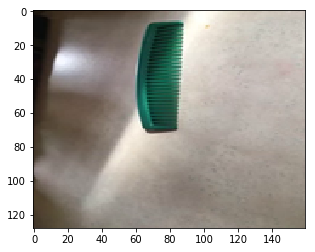

(128, 160, 3) 0.0 0.5530568 1.0


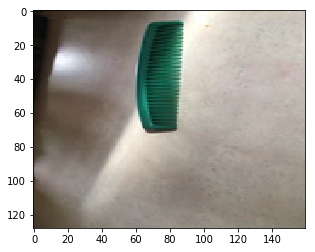

(128, 160, 3) 0.0 0.5529918 1.0


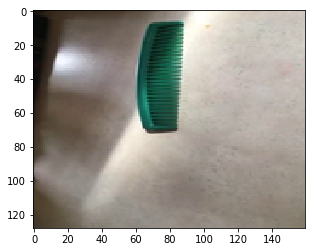

(128, 160, 3) 0.0 0.55294925 1.0


(128, 160, 3) 0.0 0.5520013 1.0


(128, 160, 3) 0.0 0.5511216 1.0


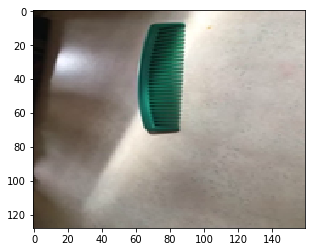

(128, 160, 3) 0.0 0.550743 1.0


(128, 160, 3) 0.0 0.54929423 1.0


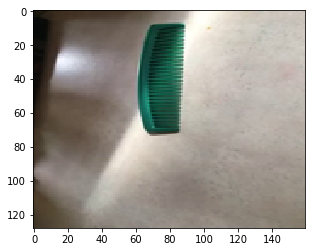

(128, 160, 3) 0.0 0.55023843 1.0


(128, 160, 3) 0.0 0.54987144 1.0


(128, 160, 3) 0.0 0.5499685 1.0


(128, 160, 3) 0.0 0.5495333 1.0


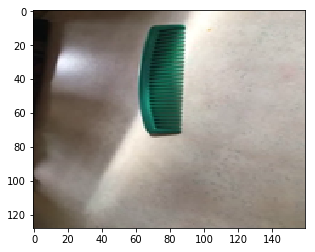

(128, 160, 3) 0.0 0.53570455 1.0


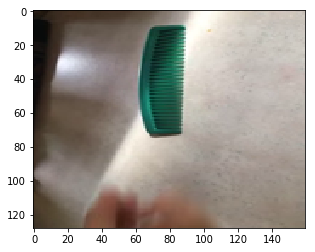

(128, 160, 3) 0.0 0.52396894 1.0


(128, 160, 3) 0.0 0.51459193 1.0


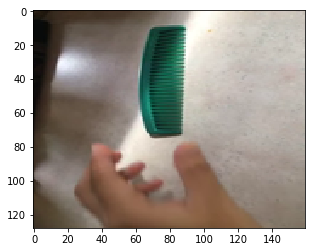

(128, 160, 3) 0.0 0.51136976 1.0


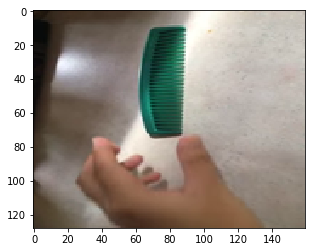

(128, 160, 3) 0.0 0.50949097 1.0


(128, 160, 3) 0.0 0.5099373 1.0


(128, 160, 3) 0.0 0.50977105 1.0


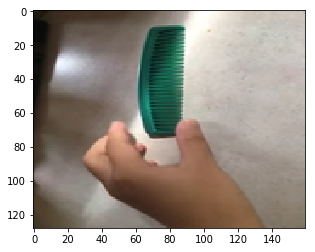

(128, 160, 3) 0.0 0.5077279 1.0


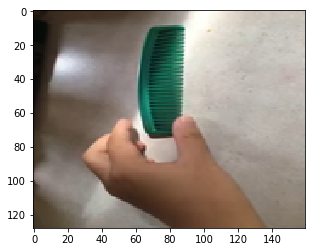

(128, 160, 3) 0.0 0.50755936 1.0


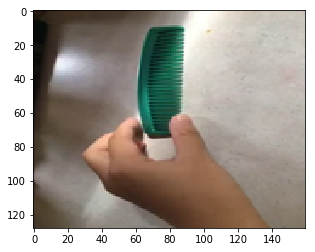

(128, 160, 3) 0.0 0.50793195 1.0


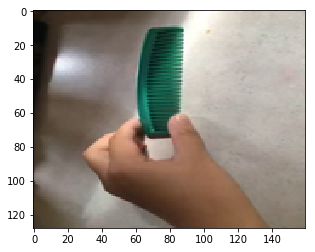

(128, 160, 3) 0.0 0.50973904 1.0


(128, 160, 3) 0.0 0.511348 1.0


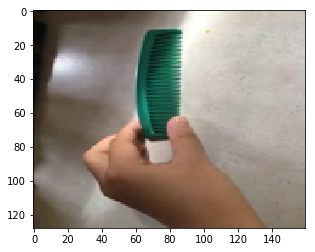

(128, 160, 3) 0.0 0.5137967 1.0


(128, 160, 3) 0.0 0.5157706 1.0


(128, 160, 3) 0.0 0.5174883 1.0


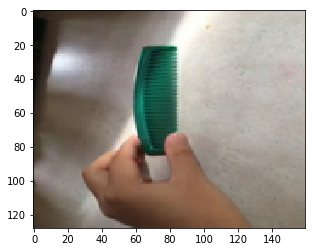

(128, 160, 3) 0.0 0.5202665 1.0


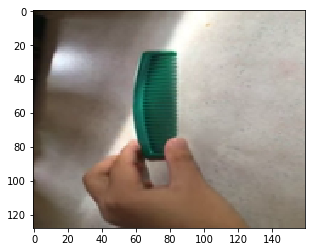

(128, 160, 3) 0.0 0.52381843 1.0


(128, 160, 3) 0.0 0.5267572 1.0


(128, 160, 3) 0.0 0.5162472 1.0


(128, 160, 3) 0.0 0.5154275 1.0


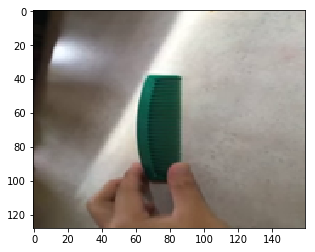

(128, 160, 3) 0.0 0.51757616 1.0


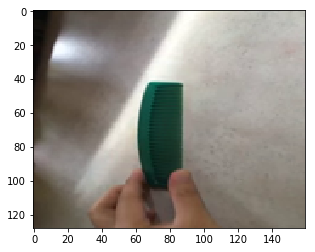

(128, 160, 3) 0.003921569 0.51921856 1.0


(128, 160, 3) 0.0 0.5209144 1.0


(128, 160, 3) 0.0 0.51227725 1.0


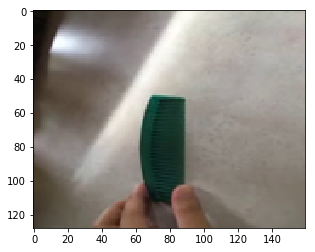

(128, 160, 3) 0.003921569 0.5029488 1.0


(128, 160, 3) 0.0 0.49880296 1.0


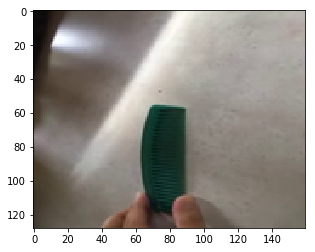

(128, 160, 3) 0.0 0.494588 1.0


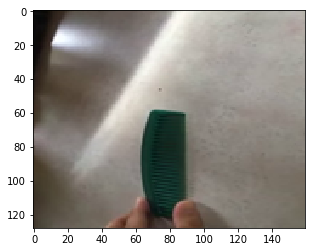

(128, 160, 3) 0.0 0.49546155 1.0


(128, 160, 3) 0.0 0.49868837 1.0


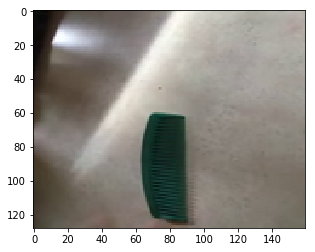

(128, 160, 3) 0.003921569 0.5012233 1.0


(128, 160, 3) 0.0 0.50405914 1.0


(128, 160, 3) 0.0 0.50319695 1.0


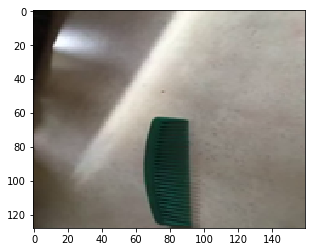

(128, 160, 3) 0.0 0.49992177 1.0


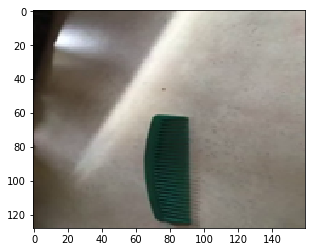

(128, 160, 3) 0.0 0.50042474 1.0


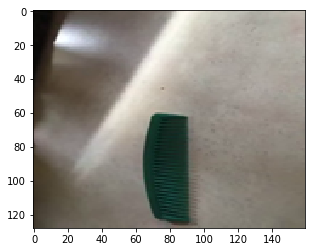

(128, 160, 3) 0.0 0.5004275 1.0


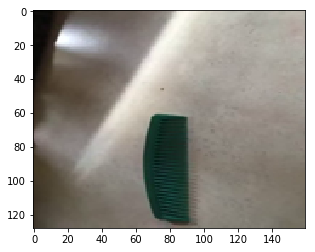

In [9]:
frames = next(val_generator)[0][0]
for frm in frames:
    print(frm.shape ,np.min(frm), np.mean(frm), np.max(frm))
    plt.imshow(frm)
    plt.show() 

In [10]:
#preprocessed_img_data_gen = ImageDataGenerator(data_format=data_format)
#preprocessed_img_data_gen.fit(self.X)
#model.fit_generator(preprocessed_img_data_gen.flow(x_train, y_train, batch_size=32),
#             steps_per_epoch=len(x_train) / 32, epochs=epochs)
# see dataset_smthsmth_analysis notebook for the analysis

## Todos
1. Is `smthsmthGenerator.create_all()` method required ? If yes, implement. 
2. Analyse other preprocessing and data augumentations and implement the ones that might be necessary in `smthsmthGenerator.preprocess()` method 
3. Implement 